In [1]:
import pandas as pd
import numpy as np
import greek_accentuation.characters as gachar
import greek_accentuation.syllabify as gasyb
pd.set_option('display.max_columns', None)
import math

from nltk.tokenize.regexp import WhitespaceTokenizer
import matplotlib.pyplot as plt
import scipy.stats as sp


#nb: punkt had to be downloaded to use tokenize.

#performing a bag-of-words-type analysis of vowel frequency, treating date as a discrete variable.

In [2]:
df=pd.read_csv('dated_inscriptions.csv').drop('Unnamed: 0',axis=1)

In [3]:
#replacing non-vowels with whitespace. 
#eliminates stray english characters.

def remove_consonants(row):
    text= row['string']
    newtext=""
    vowel_count=0
    if text != None:
        for grkchar in text:
            if gasyb.is_vowel(grkchar):
                newtext=newtext+grkchar
                vowel_count=vowel_count+1
            else:
                newtext=newtext+" "
    return pd.Series([newtext,vowel_count])
sr=df.apply(remove_consonants, axis=1)
df['vowels']=sr[0]
df['vowel_count']=sr[1]
df.to_csv('vowels_only_from_inscriptions.csv') #stashing data for later use

In [4]:
#for each vowels-and-whitespace textstring, 
#make a count of the vowels and a list of which vowels have appeared.
#add the counts to a dataframe, then join with the original dataframe 
#to associate the counts with dates.


vowelcounts={}
vowels_counted=[]
def get_vowel_counts(row):
    xml_filename=row['xml_filenames']
    greek=row['vowels']
    vcount={}

    for char in greek:
        if char is not " ":
            return_token=gachar.base(char).lower() #strip accents, go to lower case
            if return_token in vcount:
                vcount[return_token]=vcount[return_token]+1 #count the chars
            else:
                vcount[return_token]=1
                if return_token not in vowels_counted:
                    vowels_counted.append(return_token) #maintain a list of the counted chars
    vowelcounts[xml_filename]=vcount #add the char counts to a dict with key: filename
            
throwaway=df.apply(get_vowel_counts,axis=1) #throwaway prevents print to stdout



In [5]:
counts=pd.DataFrame.from_dict(vowelcounts)
counts=pd.DataFrame.transpose(counts)
counts=counts.fillna(0) #converting to dataframe in correct orientation
counts['charsum']=counts.sum(axis=1,numeric_only=True) #adding row char sum
counts.to_csv('vowelcounts.csv') #stashing intermediate results



In [6]:
df=df.set_index('xml_filenames').join(counts) #joining to original dataframe
df=df.reset_index()



In [7]:
#pooling samples in date buckets. a sample of 10 chars from 0133 AD, eg, will skew results.

def rounded_date(date):
    x=(math.floor((date + 50)/100))*100
    return x

df['date_notBefore_rounded']=df['date_notBefore'].apply(rounded_date)
df['date_notAfter_rounded']=df['date_notAfter'].apply(rounded_date)


In [8]:
#creating dataframes sorted by earliest OR latest date, summing the char counts in each category, and
#stashing the results.

nbdf=df.drop('date_notBefore',axis=1).drop('date_notAfter',axis=1).drop('date_notAfter_rounded',axis=1).drop('charsum',axis=1)
nbdf=nbdf.groupby('date_notBefore_rounded').sum()
nbdf=nbdf.reset_index()
nbdf.to_csv('vowelcounts_by_notBefore.csv')

nadf=df.drop('date_notBefore',axis=1).drop('date_notAfter',axis=1).drop('date_notBefore_rounded',axis=1).drop('charsum',axis=1)
nadf=nadf.groupby('date_notAfter_rounded').sum()
nadf=nadf.reset_index()
nadf.to_csv('vowelcounts_by_notAfter.csv')

#going forward, analysis will be done on both sort-by-earliest and sort-by-latest.

In [9]:
nadf=nadf[nadf['vowel_count']>1000]
nbdf=nbdf[nbdf['vowel_count']>1000]
#omitting buckets with small total char counts.


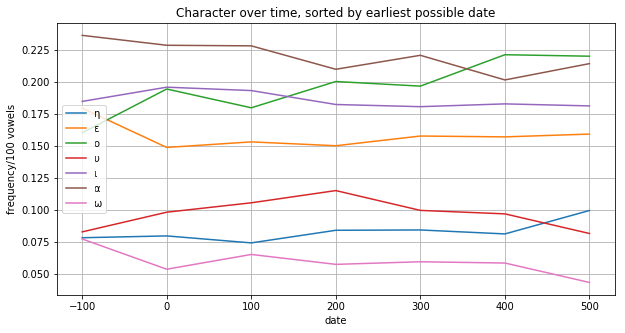

In [10]:
plt.figure(figsize=(10,5))
plt.grid(which='both')

for vowel in vowels_counted:
    plt.plot(nbdf['date_notBefore_rounded'],nbdf[vowel]/nbdf['vowel_count'],label=vowel)
plt.legend()
plt.xlabel('date')
plt.ylabel('frequency/100 vowels')
plt.title('Character over time, sorted by earliest possible date')
plt.show()

In [11]:
nbdf #the actual numbers, to give an idea of sample size and variation

,date_notBefore_rounded,vowel_count,α,ε,η,ι,ο,υ,ω
2,-100,3062,724.0,550.0,240.0,566.0,491.0,254.0,237.0
3,0,9073,2075.0,1351.0,724.0,1778.0,1765.0,892.0,488.0
4,100,15172,3463.0,2325.0,1128.0,2933.0,2729.0,1603.0,991.0
5,200,19157,4022.0,2878.0,1613.0,3495.0,3839.0,2207.0,1103.0
6,300,2617,578.0,413.0,221.0,473.0,515.0,261.0,156.0
7,400,1979,399.0,311.0,161.0,362.0,438.0,192.0,116.0
8,500,1726,370.0,275.0,172.0,313.0,380.0,141.0,75.0


In [12]:
#the percents, to give an idea of the actual frequency variation

nbdf_percents=pd.DataFrame(nbdf['date_notBefore_rounded'])
for vowel in vowels_counted:
    nbdf_percents[vowel]=nbdf[vowel]/nbdf['vowel_count']
nbdf_percents

,date_notBefore_rounded,η,ε,ο,υ,ι,α,ω
2,-100,0.078380,0.179621,0.160353,0.082952,0.184847,0.236447,0.077400
3,0,0.079797,0.148903,0.194533,0.098314,0.195966,0.228701,0.053786
4,100,0.074347,0.153243,0.179871,0.105655,0.193317,0.228249,0.065318
5,200,0.084199,0.150232,0.200397,0.115206,0.182440,0.209949,0.057577
6,300,0.084448,0.157814,0.196790,0.099733,0.180741,0.220864,0.059610
7,400,0.081354,0.157150,0.221324,0.097019,0.182921,0.201617,0.058615
8,500,0.099652,0.159328,0.220162,0.081692,0.181344,0.214368,0.043453


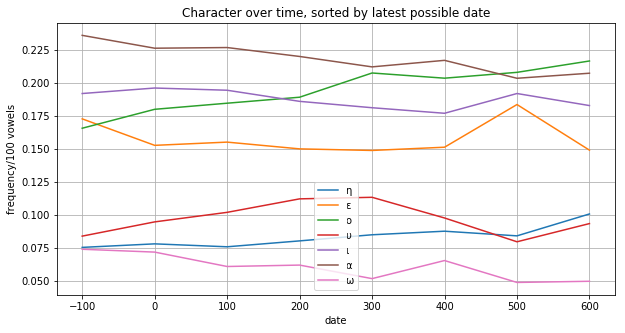

In [13]:
#the process repeated with data sorted by latest possible date.

plt.figure(figsize=(10,5))
plt.grid(which='both')

for vowel in vowels_counted:
    plt.plot(nadf['date_notAfter_rounded'],nadf[vowel]/nadf['vowel_count'],label=vowel)
plt.legend()
plt.xlabel('date')
plt.ylabel('frequency/100 vowels')
plt.title('Character over time, sorted by latest possible date')
plt.show()

In [14]:
nadf #the actual numbers

,date_notAfter_rounded,vowel_count,α,ε,η,ι,ο,υ,ω
1,-100,1406,332.0,243.0,106.0,270.0,233.0,118.0,104.0
2,0,3843,870.0,587.0,300.0,754.0,692.0,364.0,276.0
3,100,15664,3554.0,2431.0,1188.0,3047.0,2893.0,1597.0,954.0
4,200,16572,3648.0,2487.0,1331.0,3084.0,3136.0,1859.0,1027.0
5,300,10559,2241.0,1572.0,897.0,1914.0,2192.0,1197.0,546.0
6,400,2293,498.0,347.0,201.0,406.0,467.0,224.0,150.0
7,500,1557,317.0,286.0,131.0,299.0,324.0,124.0,76.0
8,600,1509,313.0,225.0,152.0,276.0,327.0,141.0,75.0


In [15]:
#the frequencies

nadf_percents=pd.DataFrame(nadf['date_notAfter_rounded'])
for vowel in vowels_counted:
    nadf_percents[vowel]=nadf[vowel]/nadf['vowel_count']
nadf_percents

,date_notAfter_rounded,η,ε,ο,υ,ι,α,ω
1,-100,0.075391,0.172831,0.165718,0.083926,0.192034,0.236131,0.073969
2,0,0.078064,0.152745,0.180068,0.094718,0.196201,0.226386,0.071819
3,100,0.075843,0.155197,0.184691,0.101954,0.194522,0.226890,0.060904
4,200,0.080316,0.150072,0.189235,0.112177,0.186097,0.220130,0.061972
5,300,0.084951,0.148878,0.207595,0.113363,0.181267,0.212236,0.051709
6,400,0.087658,0.151330,0.203663,0.097689,0.177061,0.217183,0.065416
7,500,0.084136,0.183687,0.208092,0.079640,0.192036,0.203597,0.048812
8,600,0.100729,0.149105,0.216700,0.093439,0.182903,0.207422,0.049702


In [16]:
char = 'ο'
print('\'',char,'\' linear regression pvalue, date=latest-possible: ', sp.linregress(nadf['date_notAfter_rounded'],nadf[char])[3])
print('\'',char,'\' linear regression pvalue, date=earliest-possible: ', sp.linregress(nbdf['date_notBefore_rounded'],nbdf[char])[3])



' ο ' linear regression pvalue, date=latest-possible:  0.599360859206
' ο ' linear regression pvalue, date=earliest-possible:  0.526570855478
